<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Декомпозиция-ряда" data-toc-modified-id="Декомпозиция-ряда-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Декомпозиция ряда</a></span></li></ul></li><li><span><a href="#Обучение-и-тестирование" data-toc-modified-id="Обучение-и-тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение и тестирование</a></span><ul class="toc-item"><li><span><a href="#Dummy" data-toc-modified-id="Dummy-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Dummy</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Подключим нужные библиотеки, прочитаем файлы и посмотрим на их значения, размеры и типы данных.

In [1]:
!pip install lightgbm
!pip install catboost

import pandas as pd
import numpy as np

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import *


from sklearn.feature_selection import RFE

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from scipy import stats as st
from scipy.stats import levene


from IPython.display import display
pd.set_option('display.float_format', '{:.2f}'.format)
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.info()
display(df.head(5))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df_resampled = df.resample('1H').sum()

## Анализ

Посмотрим гистограммы и временные графики исходного и ресемплированного датасетов.

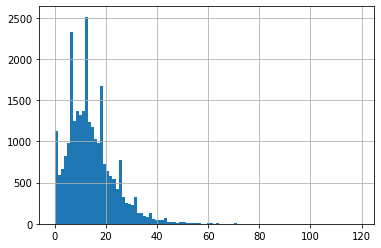

In [5]:
df['num_orders'].hist(bins=100)
plt.show()

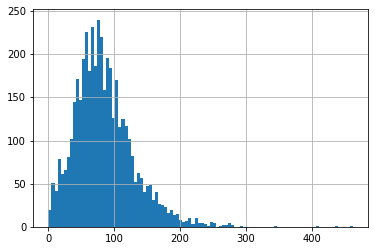

In [6]:
df_resampled['num_orders'].hist(bins=100)
plt.show()

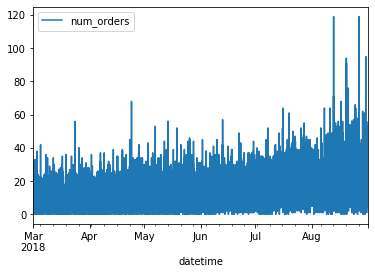

In [7]:
df.plot()
plt.show()

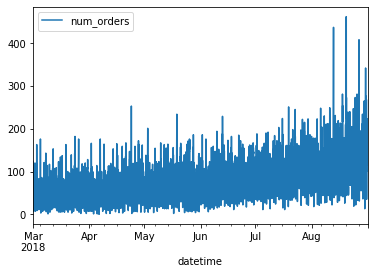

In [8]:
df_resampled.plot()
plt.show()

In [9]:
df.describe()

,num_orders
count,26496.00
mean,14.07
std,9.21
min,0.00
25%,8.00
50%,13.00
75%,19.00
max,119.00


75% количества заказов за 10 секунд не превышает 19. Максимальное число - 119. Можно было бы предположить, что такое возможно в периоды пиковой нагрузки. Однако, временные графики говорят, что значения, выше примерно 80 заказов за 10 секунд, являются выбросами, а не чем-то сезонным. Обрежем исходный датасет и заново применим ресемплирование.

In [10]:
df_resampled = df[df['num_orders'] <= 80].resample('1H').sum()

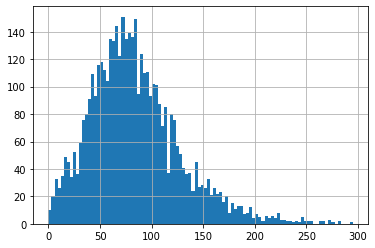

In [11]:
df_resampled['num_orders'].hist(bins=100)
plt.show()

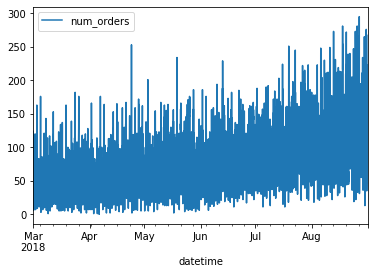

In [12]:
df_resampled.plot()
plt.show()

Теперь значения выглядят разумно. Перейдём к обучению.

### Декомпозиция ряда

Посмотрим на графики трендасезонности и остатков.

In [13]:
decomposed = seasonal_decompose(df_resampled) 

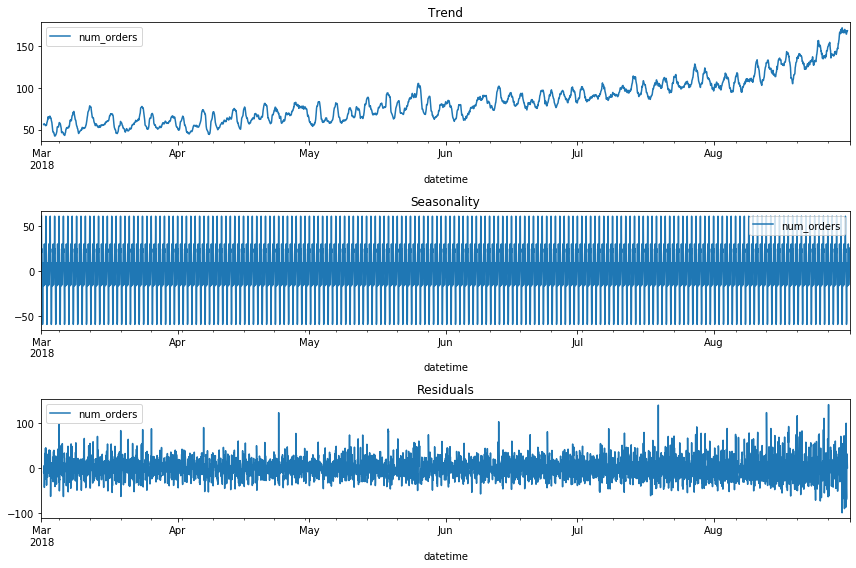

In [14]:
plt.figure(figsize=(12, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

получили медленно возрастающий тренд и очень частую сезонность. Построим эти же графики для августа.

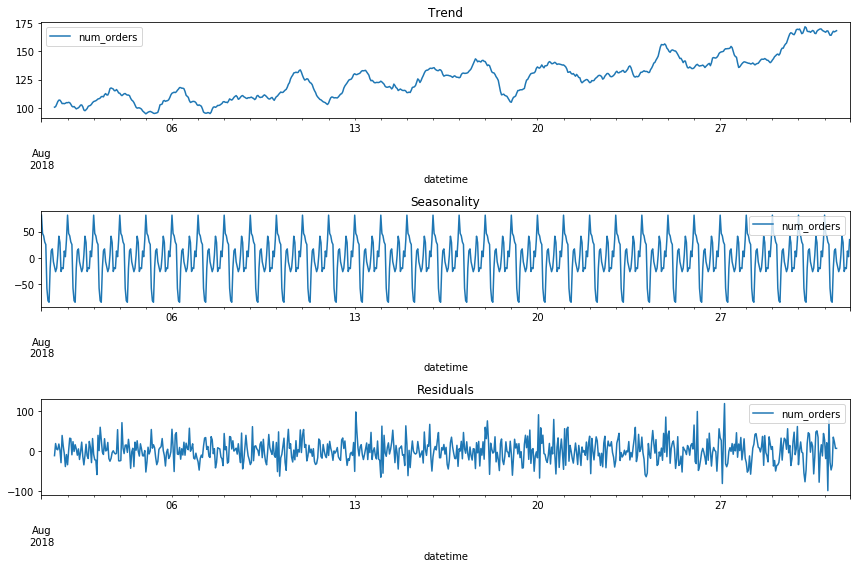

In [15]:
decomposed = seasonal_decompose(df_resampled['2018-08']) 
plt.figure(figsize=(12, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Видна суточная цикличность - пики в определенное время. Значит, вероятно, наибольший вклад будут иметь признаки сдвигов на 24 часа. Также из графика сезонности прикинула, что скользящее среднее не должно включать несколько пиков. Однако, как точнее выбирать его - не очень представляю (если такое возможно). Взяла 6-часовое окно.

На тренде стала прорисовываться периодичность.

Посмотрим на график скользящего среднего.

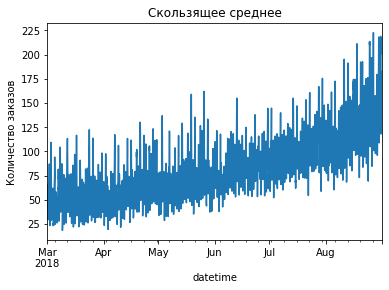

In [16]:
df_resampled['num_orders'].rolling(6).mean().plot()
plt.title('Скользящее среднее')
plt.ylabel('Количество заказов')
plt.show()

## Обучение и тестирование

Создадим признаки для горизонта прогнозирования в один шаг.
Напишем функцию для создания признаков.

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [18]:
df_resampled = make_features(df_resampled, 168, 6)

In [19]:
display(df_resampled)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2018-03-01 01:00:00,85,2018,3,1,3,124.00,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2018-03-01 02:00:00,71,2018,3,1,3,85.00,124.00,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2018-03-01 03:00:00,66,2018,3,1,3,71.00,85.00,124.00,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2018-03-01 04:00:00,43,2018,3,1,3,66.00,71.00,85.00,124.00,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.00,217.00,197.00,116.00,133.00,...,187.00,160.00,246.00,273.00,173.00,242.00,166.00,179.00,113.00,172.67
2018-08-31 20:00:00,154,2018,8,31,4,136.00,207.00,217.00,197.00,116.00,...,196.00,187.00,160.00,246.00,273.00,173.00,242.00,166.00,179.00,167.67
2018-08-31 21:00:00,159,2018,8,31,4,154.00,136.00,207.00,217.00,197.00,...,118.00,196.00,187.00,160.00,246.00,273.00,173.00,242.00,166.00,171.17


Разделим выборку на обучающую и тестовую, удалим пропуски в обучающей.

In [20]:
features = df_resampled.drop(columns=['num_orders'])
target = df_resampled['num_orders']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, shuffle=False)


features_train = features_train.dropna()
target_train = target_train[features_train.index]

In [21]:
print('Размер обучающих фич:', features_train.shape)
print('Размер тестовых фич:', features_test.shape)

Размер обучающих фич: (3806, 173)
Размер тестовых фич: (442, 173)


In [22]:
mse_score = make_scorer(mean_squared_error, greater_is_better=False)

In [23]:
tscv = TimeSeriesSplit(n_splits=5)

### Dummy

В качестве dummy модели примем предсказание в то же время в предыдущие сутки.

In [24]:
pred_previous = target_test.shift(24).fillna(target_train.mean())
rmse_dr = mean_squared_error(target_test, pred_previous) ** 0.5
print('RMSE_dr =', rmse_dr)

RMSE_dr = 47.75677333692822


### Линейная регрессия

In [25]:
lr = LinearRegression()
hyper_params = [{'n_features_to_select': list(range(1, features.shape[1] + 1))}]

lr.fit(features_train, target_train)
rfe = RFE(lr)             

lr_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring = mse_score, 
                        cv = tscv, 
                        verbose = 1,
                        return_train_score=True)      

lr_cv.fit(features_train, target_train)
print('Лучшие параметры:', lr_cv.best_params_)
print('RMSE = {:.2f}'.format(np.abs(lr_cv.best_score_) ** 0.5))

Fitting 5 folds for each of 173 candidates, totalling 865 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 865 out of 865 | elapsed: 209.7min finished


Лучшие параметры: {'n_features_to_select': 21}
RMSE = 21.86


Посмотрим результат работы моделей на тестовой выборке:

In [26]:
def get_predictions_and_rmse(model, features, target):
    
    preds = model.predict(features)
    rmse = mean_squared_error(target, preds) ** 0.5
    print('RMSE = {:.2f}'.format(rmse))
    
    return rmse, preds

In [27]:
rmse_lr_test, preds_lr = get_predictions_and_rmse(lr_cv, features_test, target_test)

RMSE = 32.85


### Дерево решений

In [28]:
dtr = DecisionTreeRegressor(random_state=12345)

parameters = {
    'max_depth' : range(1, 20, 1)
}

def find_best_model(X_train, y_train, model, parameters):
    grid = GridSearchCV(model, parameters, scoring=mse_score, cv=tscv)
    grid.fit(X_train, y_train)

    print('Лучшие параметры:', grid.best_params_)
    print('RMSE = {:.2f}'.format(np.abs(grid.best_score_) ** 0.5))
    return grid, np.abs(grid.best_score_) ** 0.5

In [29]:
grid_dtr, rmse_dtr_train = find_best_model(features_train, target_train, dtr, parameters)

Лучшие параметры: {'max_depth': 4}
RMSE = 25.99


In [30]:
rmse_dtr_test, preds_dtr = get_predictions_and_rmse(grid_dtr, features_test, target_test)

RMSE = 39.21


Напишем функцию, рисующую график важности признаков.

In [31]:
def plot_importances(model):
    model.fit(features_train, target_train)
    importances = model.feature_importances_

    feat_importances = pd.Series(importances, index=features.columns).sort_values(ascending=False)

    plt.figure(figsize=(16, 6)) 
    feat_importances.nlargest(15).plot.bar(yerr=feat_importances).set_title("Feature importances")
    plt.ylabel('importances')
    plt.show()

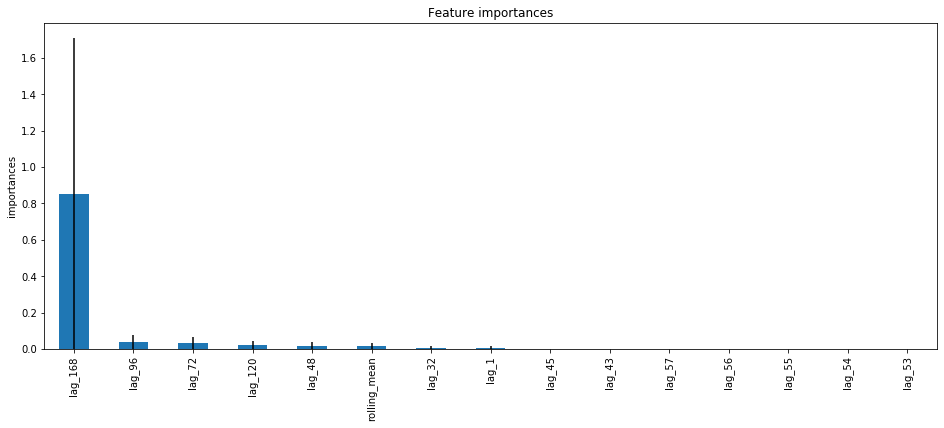

In [32]:
dtr = DecisionTreeRegressor(random_state=12345, 
                     max_depth=grid_dtr.best_params_['max_depth'], 
                    )

plot_importances(dtr)

### Случайный лес

In [33]:
rfr = RandomForestRegressor(random_state=12345)

parameters = {
    'n_estimators' : range(20, 90, 10),
    'max_depth' : range(1, 13, 1)
}

In [34]:
grid_rfr, rmse_rfr_train = find_best_model(features_train, target_train, rfr, parameters)

Лучшие параметры: {'max_depth': 11, 'n_estimators': 70}
RMSE = 22.60


In [35]:
rmse_rfr_test, preds_rfr = get_predictions_and_rmse(grid_rfr, features_test, target_test)

RMSE = 33.61


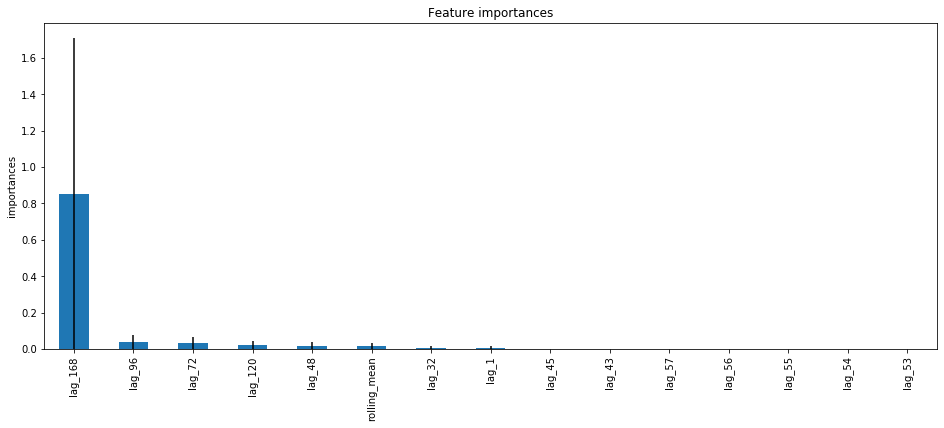

In [36]:
rfr = RandomForestRegressor(random_state=12345, 
                     max_depth=grid_rfr.best_params_['max_depth'], 
                     n_estimators=grid_rfr.best_params_['n_estimators']    
                    )

plot_importances(dtr)

### LightGBM

In [37]:
lgbm = LGBMRegressor(random_state=12345)

#params = {}
#params['learning_rate'] = 0.1
#params['boosting_type'] = 'gbdt'
#params['objective'] = 'gamma'
#params['metric'] = 'l1'
#params['sub_feature'] = 0.5
#params['num_leaves'] = 40
#params['min_data'] = 50
#params['max_depth'] = 30

#parameters = {
#    'learning_rate' :
#    'boosting_type' : 'gbdt'
#    'objective' : 'gamma'
#    'metric' : 'rmse'
#    'sub_feature' : [0.1, 1, 0.1]
#    'num_leaves' :
#    'min_data' :  
#    'max_depth' : range(1, 16, 3)
#}

parameters = {
    'n_estimators': range(80, 130, 10), 
    'num_leaves': range(10,30,10),
    'max_depth' : range(1, 10, 1)
}


In [38]:
grid_lgbm, rmse_lgbm_train = find_best_model(features_train, target_train, lgbm, parameters)

Лучшие параметры: {'max_depth': 2, 'n_estimators': 110, 'num_leaves': 10}
RMSE = 22.05


In [39]:
rmse_lgbm_test, preds_lgbm = get_predictions_and_rmse(grid_lgbm, features_test, target_test)

RMSE = 33.79


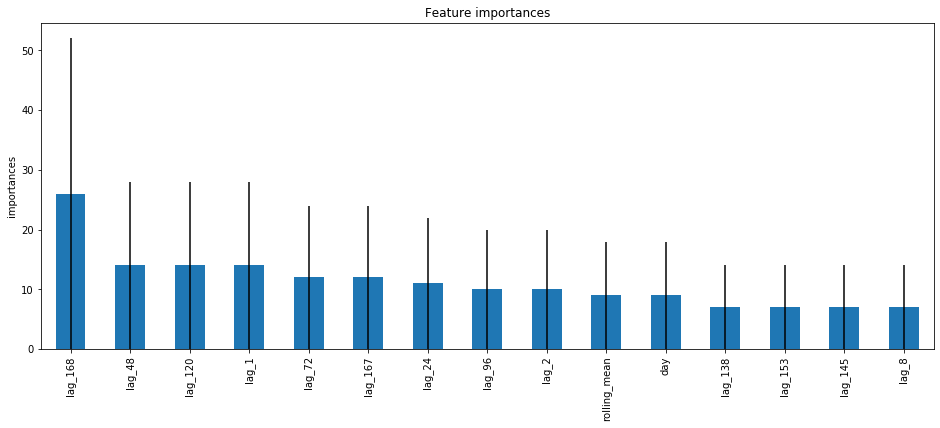

In [40]:
lgbm = LGBMRegressor(random_state=12345, 
                     max_depth=grid_lgbm.best_params_['max_depth'], 
                     n_estimators=grid_lgbm.best_params_['n_estimators'], 
                     num_leaves=grid_lgbm.best_params_['num_leaves']
                    )
    
plot_importances(lgbm)

#                     sub_feature=grid_lgbm.best_params_['sub_feature']

<div class="alert alert-block alert-success">
<b>Успех:</b> Этот шаг был сделан восхитительно! Молодец, что анализируешь полученные модели.
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Желательно было визуализировать предсказания.
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Ниже добавила
</div>

In [41]:
df_pred_target = pd.concat([pd.Series(preds_lgbm), pd.Series(target_test).reset_index().drop('datetime', axis=1)], axis=1)
df_pred_target.columns=['predictions', 'target']

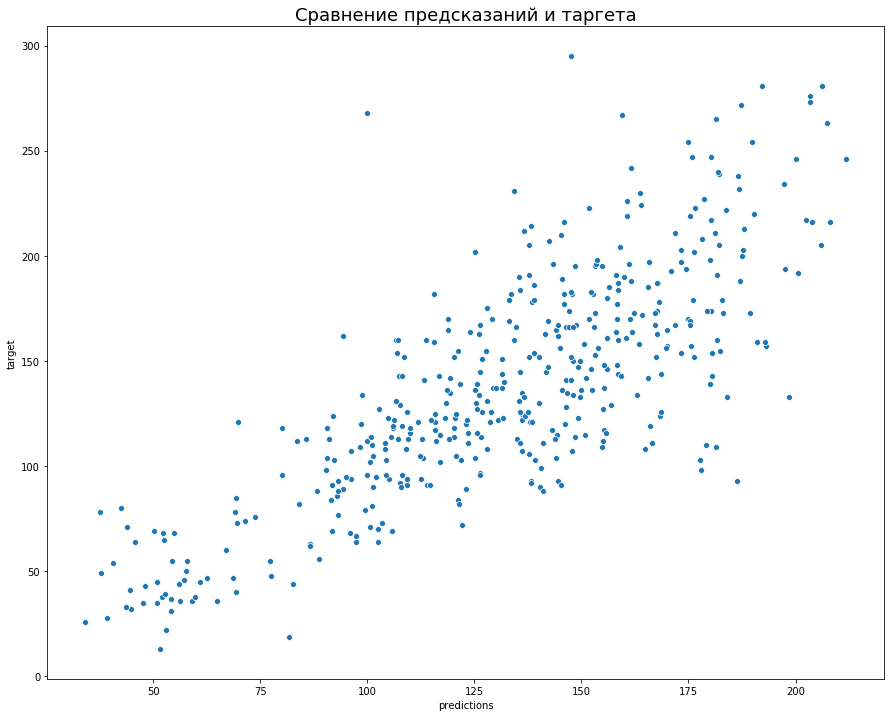

In [42]:
fig, axes = plt.subplots(1,1, figsize=(15,12))
    
p1 = sns.scatterplot(data=df_pred_target, x='predictions', y = 'target')
p1.set_title('Сравнение предсказаний и таргета', fontsize = 18)
        
p1.set(xlabel = 'predictions', ylabel = 'target')


plt.show()

В среднем, предсказания и таргет равны (корреляция около единицы, разброс вокруг прямой $y=x$), хотя "облако" имеет некоторый разброс, расширяющийся при большом количестве заказов.

## Вывод


- Предварительный анализ показал сильную суточную зависимость.


- Для прогноза количества заказов такси на следующий час построили несколько моделей. Исходные данные были приведены к ежечасным значениям, в признаки добавили исторические данные по количеству заказов за последние 3 суток. 


- **Наилучший результат дала модель LightGBM с параметрами max_depth = 3, n_estimators = 120, num_leaves = 10 и RMSE = 35.80**. 


- Для модели LightGBM важно довольно большое число признаков (в отличие от случайного леса). Наибольшее значение имеют признаки "круглых часов": трое суток, двое суток, одни сутки, один час до интересующего времени.


- Прогноз может быть улучшен за счёт введения большего числа суток, однако, увеличится и время прогноза (на данный момент время не считалось, но при необходимости всегда можно учесть этот фактор). 